# **Can Words Reveal Mental Health? A Machine Learning Approach**

## **Aim of the Project**

The aim of this project is to explore whether machine learning models can accurately predict an individual's mental health status based on the content of their written statements.

By analyzing text data utilizing Natural Language Processing (NLP) and range of machine learning (ML) techniques, I aim to detect mental health conditions such as depression, anxiety, or bi-polar disorder and others, given a text input. The central research question guiding this project is:

**Can text-based features from individual's written statements be used to accurately predict their mental health status using machine learning techniques?**

## **Scope of the project**

The project follows a structured pipeline with the following key phases.

1. **Data Preprocessing**: This step involves cleaning the text, removing NAs and duplicates, tokenization, lemmatization and transforming the text into numerical representations using TF-IDF.

2. **Exploratory Data Analysis** (EDA): EDA is used to gain sinsights into the distribution of mental health categories, the frequency of specific words, as well as relationships between features and mental health statuses.

3. **Model Building and Evaluation**: Multiple classification algorithms are trained and evaluated, including:
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Machine (SVM)
- XGBoost
- A feedforward neural network


Model performance will be assessed using accuracy, F1 scores (micro and macro), and confusion matrices to understand how well each model captures the nuances of mental health categories.


## **Dataset**

The dataset is sourced from Kaggle:
https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data

The dataset is a compilation of statements from various publicly availale health datasets and includes labels of one of seven mental health statuses:
- Normal
- Depression
- Suicidal
- Anxiety
- Stress
- Bi-Polar
- Personality Disorder

In total there are 3 columns (`unique_id`, `statement`, `status`) and 53043 rows.

In [ ]:
import pandas as pd
import string # for removing punctuaation
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data Preprocessing

In this section, the data is cleaned and preprocessed for the modelling.

## 1.1 Load and Inspect the Dataset

In [ ]:
data = pd.read_csv("combined_data.csv", index_col = 0, header = 0)

data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.shape

(53043, 2)

## 1.2. Handle Missing Values and Duplicates

In [ ]:
data.isnull().sum()

,0
statement,362
status,0


Since barely 0.6% of data is missing, it was decided to drop rows with missing values.

In [ ]:
data = data.dropna(axis = 0, how = "any")

In [ ]:
# convert all text and labeles to lowercase (maybe you can bring it later?? check if it makes difference!!!)
data["statement"] = data["statement"].str.lower()
data["status"] = data["status"].str.lower()
data.head()

,statement,status
0,oh my gosh,anxiety
1,"trouble sleeping, confused mind, restless hear...",anxiety
2,"all wrong, back off dear, forward doubt. stay ...",anxiety
3,i've shifted my focus to something else but i'...,anxiety
4,"i'm restless and restless, it's been a month n...",anxiety


In [ ]:
# find duplicate entries based on both statement and label
duplicates = data[data.duplicated(subset = ("statement", "status"), keep = False)]
print("Examples of duplicated rows (same statement & label): ")
print(duplicates.head(10))

Examples of duplicated rows (same statement & label): 
                                             statement   status
18   "no regrets or grudges/angry at things that ha...  anxiety
39   but my heart is still restless even though my ...  anxiety
56                                    why am i nervous  anxiety
88                                             anxious  anxiety
97   "no regrets or grudges/angry at things that ha...  anxiety
132  i want to exhale the restlessness in my chest ...  anxiety
138  but my heart is still restless even though my ...  anxiety
155                              restless and agitated  anxiety
167  i want to exhale the restlessness in my chest ...  anxiety
168                  restless restlessness accompanies  anxiety


In [ ]:
# remove duplicates, keeping the first occurence
data = data.drop_duplicates(subset=["statement", "status"], keep="first")
data.shape

(51071, 2)

## 1.3 Text Cleaning

In [ ]:
def clean_text(text):
    """
    This function clean text by removing URLs, handles, punctuation, numbers
    and extra whitespaces.
    """
    # remove URL links and markdown-style links
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # remove handles starting with @ (e.g., usernames)
    text = re.sub(r'@\w+', '', text)

    # replace newline with space
    text = text.replace("\n", " ")

    # remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove extra whitespaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
# apply text cleaning
data['statement'] = data['statement'].apply(clean_text)

# remove empty strings
data = data[data['statement'].str.strip() != ""] # check this????

In [ ]:
data.head()

,statement,status
0,oh my gosh,anxiety
1,trouble sleeping confused mind restless heart ...,anxiety
2,all wrong back off dear forward doubt stay in ...,anxiety
3,ive shifted my focus to something else but im ...,anxiety
4,im restless and restless its been a month now ...,anxiety


## 1.4 Tokenization

Tokenization is a process of breaking text into words (tokens).

In [ ]:
data["tokens"] = data["statement"].apply(word_tokenize)
data.head()

,statement,status,tokens
0,oh my gosh,anxiety,"[oh, my, gosh]"
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ..."
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ..."
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,..."
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo..."


## 1.5 Lemmatization

Lemmatization reduces words to their dictionary base form (lemma) using vocabulary and morphological analysis. It was chosen because it always produces valid dictionary words, unlike stemming.

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_pos_tag(pos_tag):
  """
  This function maps POS tags to WordNet tags.
  """
  if pos_tag.startswith('J'):
    return wordnet.ADJ
  elif pos_tag.startswith('V'):
    return wordnet.VERB
  elif pos_tag.startswith('N'):
    return wordnet.NOUN
  elif pos_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


def lemmatize(tokens):
  """
  This function lemmatizes a list of tokens using POS tagging.
  """
  pos_tags = pos_tag(tokens)
  lemmatized  = [lemmatizer.lemmatize(token, get_pos_tag(pos)) for token, pos in pos_tags]
  return " ".join(lemmatized)

# apply lemmatization
data["lemmatized"] = data["tokens"].apply(lemmatize)
data.head()

,statement,status,tokens,lemmatized
0,oh my gosh,anxiety,"[oh, my, gosh]",oh my gosh
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ...",trouble sleep confuse mind restless heart all ...
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,...",ive shift my focus to something else but im st...
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it be a month now boy...


## 1.6 Feature Engineering

Two numerical features are created:
- `number_of_characters`: The total number of characters in each statement.
- `text_length`: The number of words in each statement (after tokenization by whitespace).

In [ ]:
data["number_of_characters"] = data["statement"].str.len()
data["text_length"] = data["statement"].apply(lambda x: len(x.split()))
data.head()

,statement,status,tokens,lemmatized,number_of_characters,text_length
0,oh my gosh,anxiety,"[oh, my, gosh]",oh my gosh,10,3
1,trouble sleeping confused mind restless heart ...,anxiety,"[trouble, sleeping, confused, mind, restless, ...",trouble sleep confuse mind restless heart all ...,61,10
2,all wrong back off dear forward doubt stay in ...,anxiety,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...,75,14
3,ive shifted my focus to something else but im ...,anxiety,"[ive, shifted, my, focus, to, something, else,...",ive shift my focus to something else but im st...,59,11
4,im restless and restless its been a month now ...,anxiety,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it be a month now boy...,66,14


# 2. Exploratory Data Analysis (EDA)

To understand the structure and characteristics of the dataset, the EDA is performed.

## 2.1 Class distribution

In [ ]:
counts = data["status"].value_counts()
status = list(data["status"].unique())

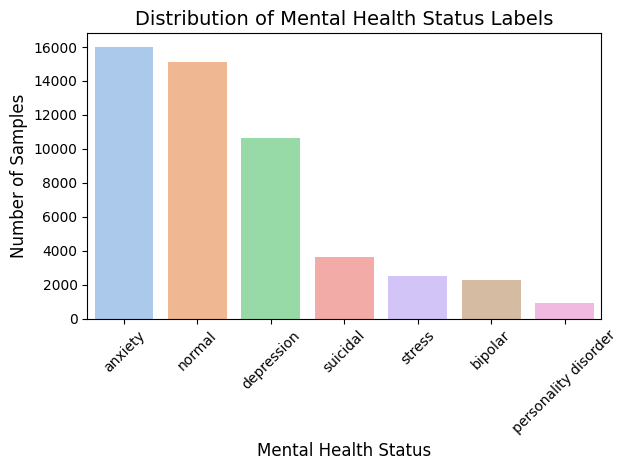

In [ ]:
sns.barplot(x = status, y = counts, hue = status, legend = False, palette = 'pastel')

plt.title("Distribution of Mental Health Status Labels", fontsize=14)
plt.xlabel("Mental Health Status", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The dataset is imbalanced, with he most represented class being `anxiety`, followed closely by `normal` and `depression` classes. Less frequent categories include `suicidal`, `stress`, `bipolar` and `personality disorder`. This imabalnce could impact the model performance, and thus resampling might be required.

## 2.2 Text Length by Class

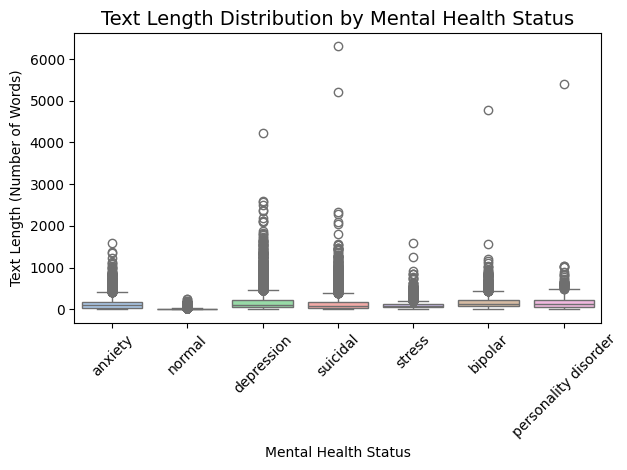

In [ ]:
sns.boxplot(data = data, x='status', y='text_length', hue = 'status', legend = False, palette = "pastel")

plt.title("Text Length Distribution by Mental Health Status", fontsize=14)
plt.xlabel("Mental Health Status")
plt.ylabel("Text Length (Number of Words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The boxplot above visualize the distirbution of word counts (text_length) for each mental health status. In general, most text are relatively short. However, several outliers exist, particularly in depression and suicidal condition, where users wrote longer statements. The normal class has consistently shorter texts with fewer extreme outliers, suggesting that individuals with no apparent mental health issues may express themselves more succintctly.

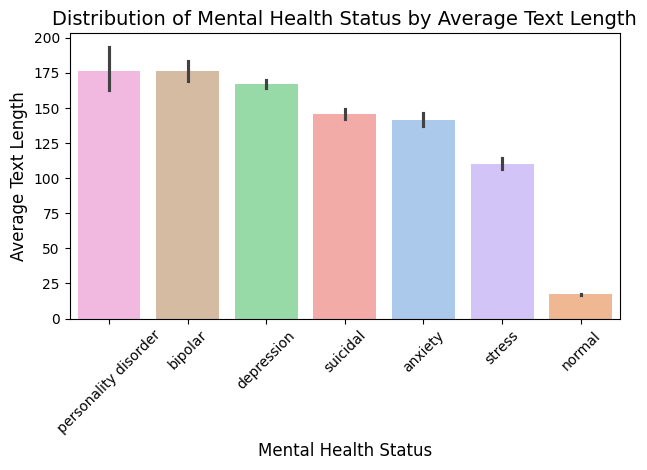

In [ ]:
ordered = data.groupby('status')['text_length'].mean().sort_values(ascending=False).index
sns.barplot( data = data, x = "status", y = "text_length", hue = "status", order = ordered, legend = False, palette = 'pastel')

plt.title("Distribution of Mental Health Status by Average Text Length", fontsize=14)
plt.xlabel("Mental Health Status", fontsize=12)
plt.ylabel("Average Text Length", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar chart above comapres the mean number of words per statement across classes. Interestingly, texts from personality disorder and bipolar classes tend to be the longest on the average, followed by depression and suicidal. Again, it can be seen that the normal class has the shortest average text length by a signifcant margin. Thus, individuals experiencing more severe mental health issues might be inclined to express themselves in longer, more elaborate messages.

SOME GENERAL SUMMARY?

## 2.3 Word Frequency Analysis

Top 20 most frequent words in the entire dataset as well as for each inidivudal mental health condition is analyzed. Next, WordClouds are created to visualize the most prominient terms.

In [ ]:
def top_words_frequency(data, label_column, text_column, label_value, n_words = 20):
    data = data[data[label_column] == label_value]
    vectorizer = CountVectorizer(stop_words = "english")
    X = vectorizer.fit_transform(data[text_column])
    sum_words = X.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words = words_freq[:n_words]

    return top_words, dict(words_freq)

In [ ]:
def wordcloud(words_frequencies, title = None, colormap = "gnuplot"):
    wordcloud = WordCloud(background_color = "white", colormap = colormap)
    wordcloud.generate_from_frequencies(words_frequencies)
    plt.figure()
    if title:
        plt.title(title)

    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

### 2.3.1 Normal Class

In [ ]:
normal_top, normal_frequencies = top_words_frequency(data, 'status', 'lemmatized', 'normal')

for word, freq in normal_top:
    print(f"{word}: {freq}")

want: 1374
im: 1344
like: 1294
just: 1275
dont: 928
time: 910
know: 859
really: 854
make: 793
work: 793
good: 771
think: 763
day: 740
people: 637
say: 617
feel: 611
come: 597
year: 533
look: 529
love: 516


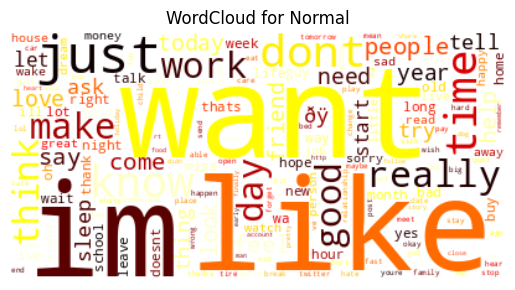

In [ ]:
wordcloud(normal_frequencies, title = 'WordCloud for Normal', colormap = "hot")

### 3.3.2 Mental Health Statuses

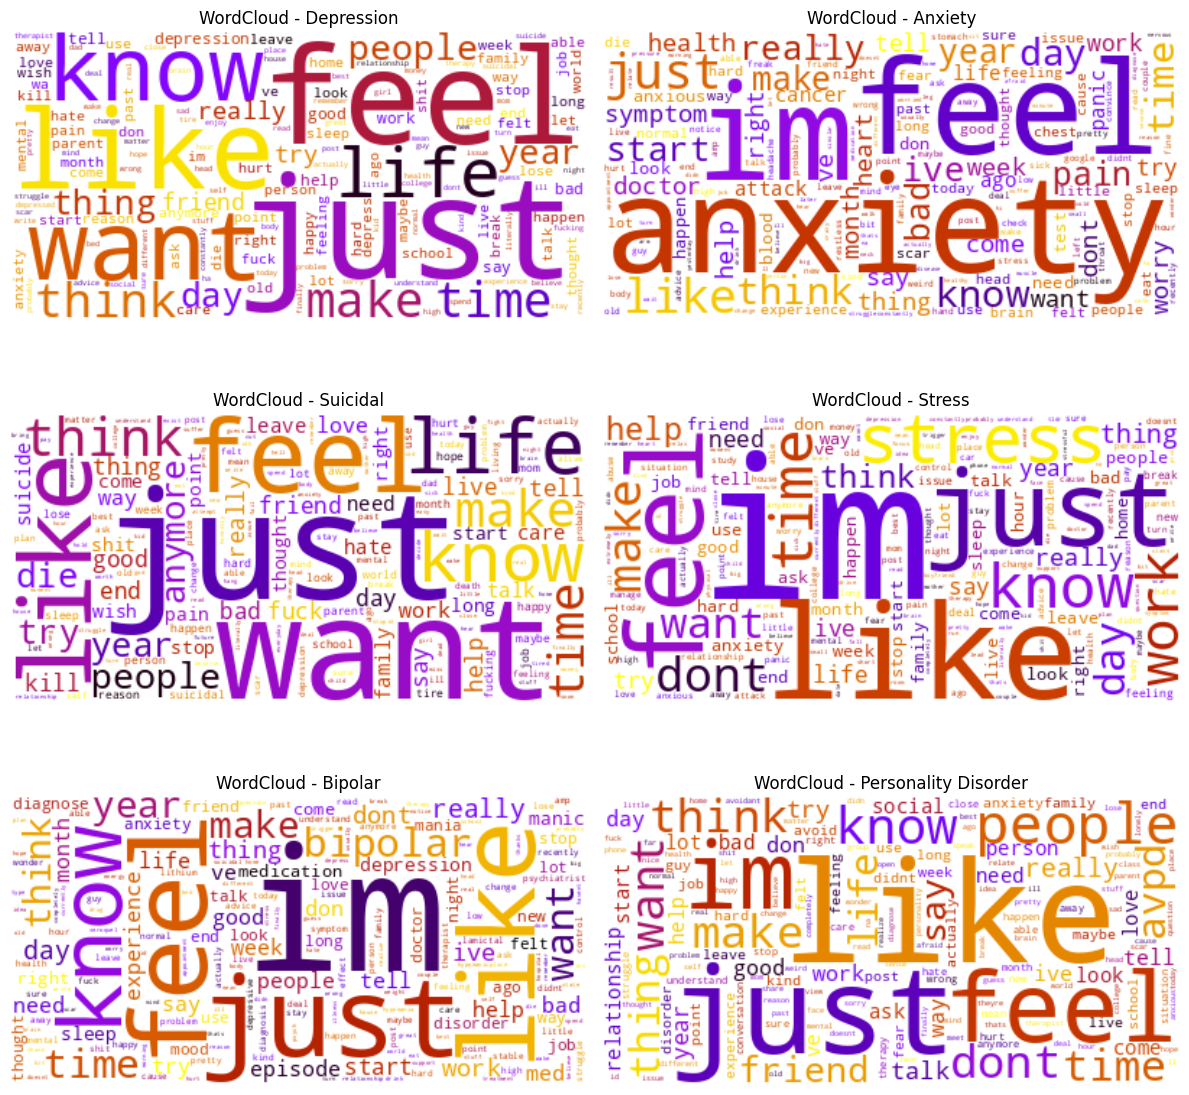

In [ ]:
#GPTT SEEE
# Temporarily remove plt.figure() and plt.show() from your function (comment them out)
def wordcloud_image(words_frequencies, colormap="gnuplot"):
    return WordCloud(background_color="white", colormap=colormap).generate_from_frequencies(words_frequencies)

# Prepare labels
statuses = ["depression", "anxiety", "suicidal", "stress", "bipolar", "personality disorder"]
titles = ["Depression", "Anxiety", "Suicidal", "Stress", "Bipolar", "Personality Disorder"]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Generate and plot each WordCloud
for i, (status_label, title) in enumerate(zip(statuses, titles)):
    row, col = divmod(i, 2)
    top_words, word_freq = top_words_frequency(data, "status", "lemmatized", status_label)
    wc = wordcloud_image(word_freq, colormap="gnuplot")  # generate WordCloud object
    axes[row][col].imshow(wc, interpolation="bilinear")
    axes[row][col].set_title(f"WordCloud - {title}", fontsize=12)
    axes[row][col].axis("off")

plt.tight_layout()
plt.show()


### 2.7.1 **Depression**

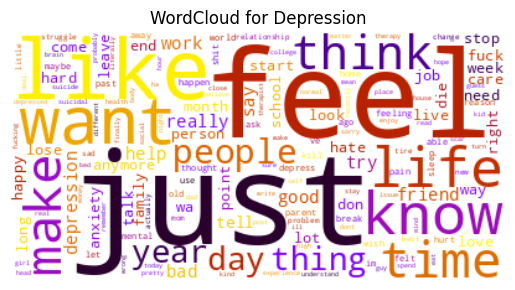

In [ ]:
wordcloud(depression_frequencies, title = 'WordCloud for Depression')

### 2.7.2 **Anxiety**

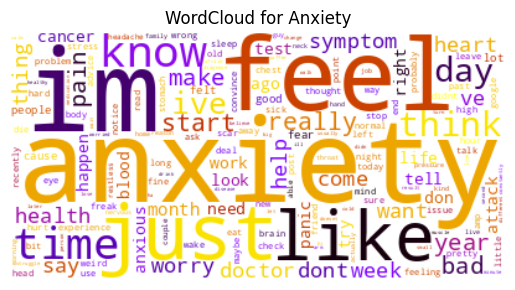

In [ ]:
wordcloud(anxiety_frequencies, title = 'WordCloud for Anxiety')

### 2.7.3 **Suicidial**

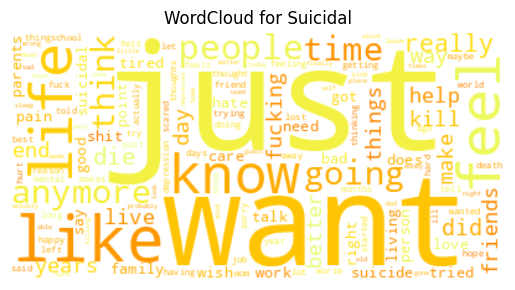

In [ ]:
wordcloud(suicidal_frequencies, title = 'WordCloud for Suicidal', colormap = "Wistia_r")

### 2.7.4 **Stress**

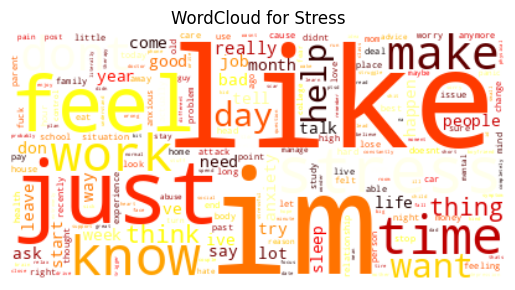

In [ ]:
wordcloud(stress_frequencies, title = 'WordCloud for Stress', colormap = "hot")

### 2.7.5 **Bi-Polar**

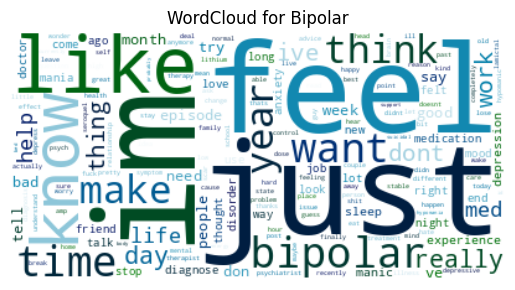

In [ ]:
wordcloud(bipolar_frequencies, title = 'WordCloud for Bipolar', colormap = "ocean")

### 2.7.6 **Personality Disorder**

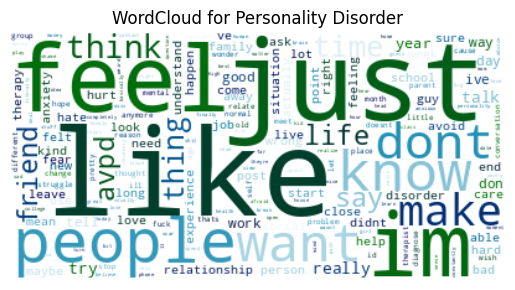

In [ ]:
wordcloud(personality_frequencies, title = 'WordCloud for Personality Disorder', colormap = "ocean")

### 2.7.7 **Normal**

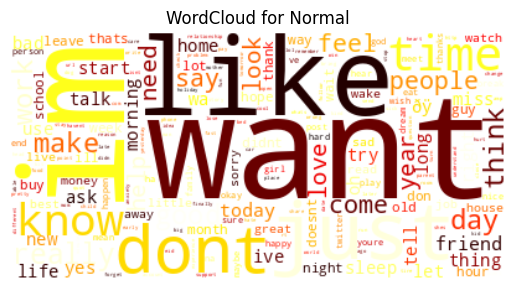

In [ ]:
wordcloud(normal_frequencies, title = 'WordCloud for Normal', colormap = "hot")wordcloud(normal_frequencies, title = 'WordCloud for Normal', colormap = "hot")

## 3. Baseline Models

In this section, several baseline models are build and evaluated using TF-IDF features extracted from the lemmatizd statements, along with optional numerical features like text length. The performance is comapred using accuracy, F1 scores and confusion matrices.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn import preprocessing

### 3.1 Data Preparation for Modeling

In [ ]:
# select features for modelling: lemmatized text and numerical features such as text length and number of characters
x = data[['lemmatized', 'number_of_characters', 'text_length']]
y = data['status']

# encode class labels into numeric format
le = preprocessing.LabelEncoder()

y = le.fit_transform(y.values)

In [ ]:
# split data into training and testing set (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
# inspect class distribution in training and test sets

# train dataset distirbution
target_counts = Counter(y_train)

total = sum(target_counts.values(), 0.0)
for key in target_counts:
    target_counts[key] /= total

print(target_counts)

Counter({np.int64(3): 0.310910261073957, np.int64(2): 0.2968631950079749, np.int64(6): 0.20992248929680724, np.int64(0): 0.07180233371575678, np.int64(1): 0.04762571004840921, np.int64(5): 0.045443098189551445, np.int64(4): 0.017432912667543442})


In [ ]:
# test dataset distirbution
target_counts = Counter(y_test)

total = sum(target_counts.values(), 0.0)
for key in target_counts:
    target_counts[key] /= total

print(target_counts)

Counter({np.int64(3): 0.319600417863672, np.int64(2): 0.2928310263776443, np.int64(6): 0.2049490728649778, np.int64(0): 0.06881692347871507, np.int64(1): 0.05216766779838078, np.int64(5): 0.043875685557586835, np.int64(4): 0.017759206059023244})


In [ ]:
# inspect class distribution in training and test sets

train_distribution = Counter(y_train)
test_distribution = Counter(y_test)

train_distribution = {k: v / sum(train_distribution.values()) for k, v in train_distribution.items()}
test_distribution = {k: v / sum(test_distribution.values()) for k, v in test_distribution.items()}

print("Training set class distribution:", train_distribution)
print("Test set class distribution:", test_distribution)

Training set class distribution: {np.int64(2): 0.2968631950079749, np.int64(3): 0.310910261073957, np.int64(6): 0.20992248929680724, np.int64(5): 0.045443098189551445, np.int64(1): 0.04762571004840921, np.int64(4): 0.017432912667543442, np.int64(0): 0.07180233371575678}
Test set class distribution: {np.int64(3): 0.319600417863672, np.int64(6): 0.2049490728649778, np.int64(2): 0.2928310263776443, np.int64(0): 0.06881692347871507, np.int64(4): 0.017759206059023244, np.int64(5): 0.043875685557586835, np.int64(1): 0.05216766779838078}


## TF-IDF Vectorization

In [ ]:
# apply TF-IDF vectorization on the lemmatized text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words = "english", max_features = 30000)

x_train_vectors = vectorizer.fit_transform(x_train["lemmatized"])
x_test_vectors = vectorizer.transform(x_test["lemmatized"])

In [ ]:
from scipy.sparse import hstack

x_train_combined = hstack([x_train_vectors, x_train[['number_of_characters', 'text_length']].values])
x_test_combined = hstack([x_test_vectors, x_test[['number_of_characters', 'text_length']].values])

In [ ]:
x_train_combined.shape

(35737, 30002)

### Re-samplign?

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_combined, y_train)

In [ ]:
x_train_resampled.shape

(77777, 30002)

In [ ]:
print("After Oversampling:")
resampled_counts = Counter(y_train_resampled)
for label, count in sorted(resampled_counts.items()):
    print(f"Class {label}: {count}")

After Oversampling:
Class 0: 11111
Class 1: 11111
Class 2: 11111
Class 3: 11111
Class 4: 11111
Class 5: 11111
Class 6: 11111


In [ ]:
labels = le.classes_

def plot_cm(y_true, y_pred, labels, title):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(title)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

### 3.1 Logistic Regression

In [ ]:
# train logistic regression model
log_reg = LogisticRegression(random_state=42, solver="liblinear", max_iter=1000)
log_reg.fit(x_train_resampled, y_train_resampled)

# predict and evaluate
pred_labels = log_reg.predict(x_test_combined)


print("Classification Report - Logistic Regression:")
print(classification_report(y_test, pred_labels))

print("F1 Micro: ", f1_score(y_test, pred_labels, average="micro"))
print("F1 Macro: ", f1_score(y_test, pred_labels, average="macro"))

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1054
           1       0.73      0.77      0.75       799
           2       0.78      0.58      0.67      4485
           3       0.87      0.90      0.89      4895
           4       0.43      0.67      0.52       272
           5       0.45      0.68      0.54       672
           6       0.65      0.70      0.67      3139

    accuracy                           0.74     15316
   macro avg       0.66      0.73      0.69     15316
weighted avg       0.75      0.74      0.74     15316

F1 Micro:  0.7418386001566989
F1 Macro:  0.6877335385117522


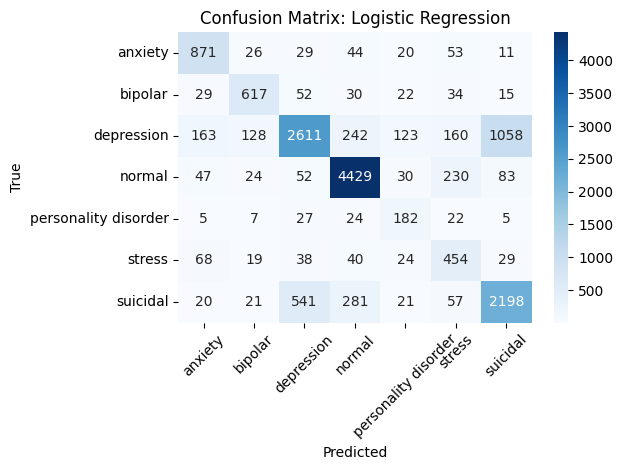

In [ ]:
plot_cm(y_test, pred_labels, labels, "Confusion Matrix: Logistic Regression")

In [ ]:
def plot_f1_perclass(y_true, y_pred, label_encoder, title = "Per-Class F1 Scores"):
  """
  This function plots per-class F1 scores for classification results.

  Parameters:
  - y_true: true labels
  - y_pred: predicted labels
  - label_encoder: fitted sklearn LabelEncoder used to decode labels
  - title: title of the plot
  """
  # get classification report as dict
  report_dict = classification_report(y_test, y_pred, output_dict=True)

  # extract per-class F1 scores
  class_names = label_encoder.classes_
  f1_scores = [report_dict[str(i)]["f1-score"] for i in range(len(class_names))]

  sns.barplot(x = class_names, y = f1_scores, hue = class_names, legend = False, palette = 'pastel')

  plt.title("Model Comparison", fontsize=14)
  plt.xlabel("Model", fontsize=12)
  plt.ylabel("F1 Micro Scores", fontsize=12)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

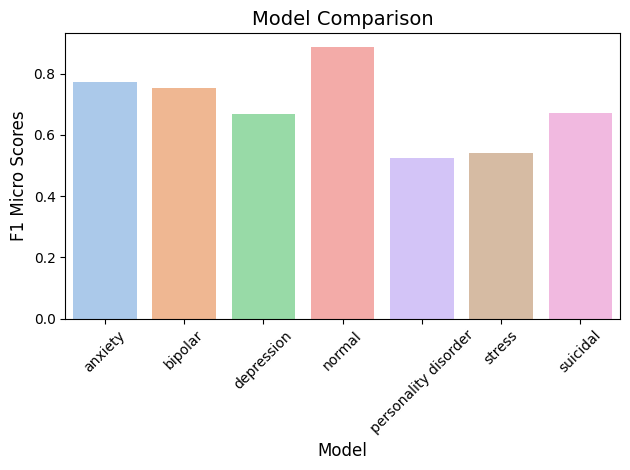

In [ ]:
plot_f1_perclass(y_test, pred_labels, label_encoder)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# traing naive bayes model
nb_model = MultinomialNB()
nb_model.fit(x_train_resampled, y_train_resampled)

MultinomialNB()

In [ ]:
# test and evaluate
nb_predictions = nb_model.predict(x_test_combined)
print("Classification Report - Naive Bayes:")
print(classification_report(y_test, nb_predictions))

print("F1 Micro:", f1_score(y_test, nb_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, nb_predictions, average="macro"))

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.60      0.80      0.69      1054
           1       0.45      0.80      0.57       799
           2       0.68      0.57      0.62      4485
           3       0.94      0.62      0.75      4895
           4       0.22      0.78      0.34       272
           5       0.28      0.51      0.36       672
           6       0.62      0.67      0.64      3139

    accuracy                           0.63     15316
   macro avg       0.54      0.68      0.57     15316
weighted avg       0.71      0.63      0.65     15316

F1 Micro: 0.6339775398276313
F1 Macro: 0.5678913942086063


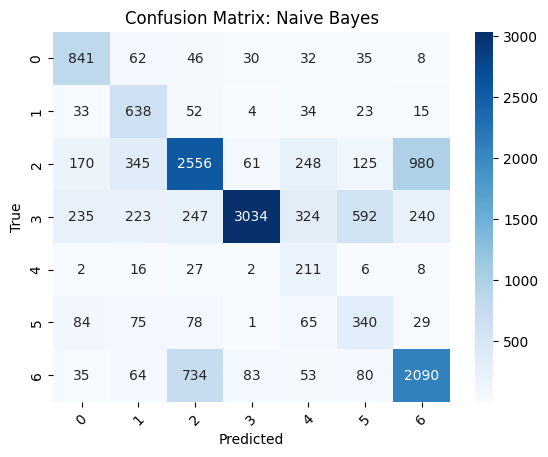

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, nb_predictions)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Naive Bayes")
plt.xticks(rotation=45)
plt.show()

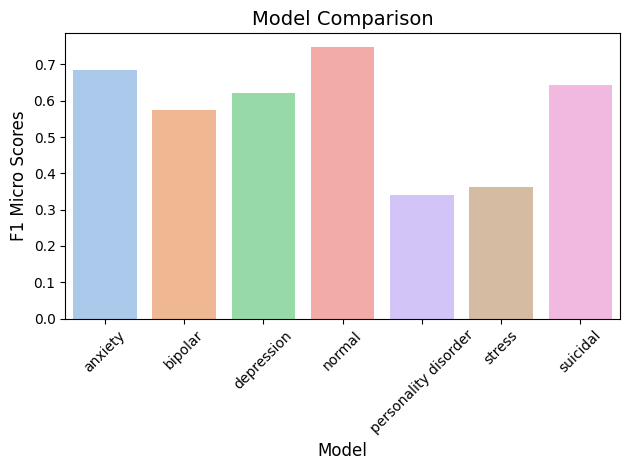

In [ ]:
plot_f1_perclass(y_test, nb_predictions, label_encoder)

## SVM??

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
# traing SVM model
svm_model = LinearSVC(class_weight = "balanced", random_state = 42, max_iter = 10000)

In [ ]:
svm_model.fit(x_train_resampled, y_train_resampled)

LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)

In [ ]:
# test and evaluate
svm_predictions = svm_model.predict(x_test_combined)

In [ ]:
print("Classification Report - SVM:")
print(classification_report(y_test, svm_predictions))

print("F1 Micro:", f1_score(y_test, svm_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, svm_predictions, average="macro"))

Classification Report - SVM:
              precision    recall  f1-score   support

           0       0.71      0.82      0.77      1054
           1       0.73      0.78      0.75       799
           2       0.78      0.57      0.66      4485
           3       0.86      0.88      0.87      4895
           4       0.45      0.67      0.54       272
           5       0.43      0.67      0.52       672
           6       0.65      0.71      0.68      3139

    accuracy                           0.73     15316
   macro avg       0.66      0.73      0.68     15316
weighted avg       0.75      0.73      0.74     15316

F1 Micro: 0.7347871506920867
F1 Macro: 0.6837731459169699


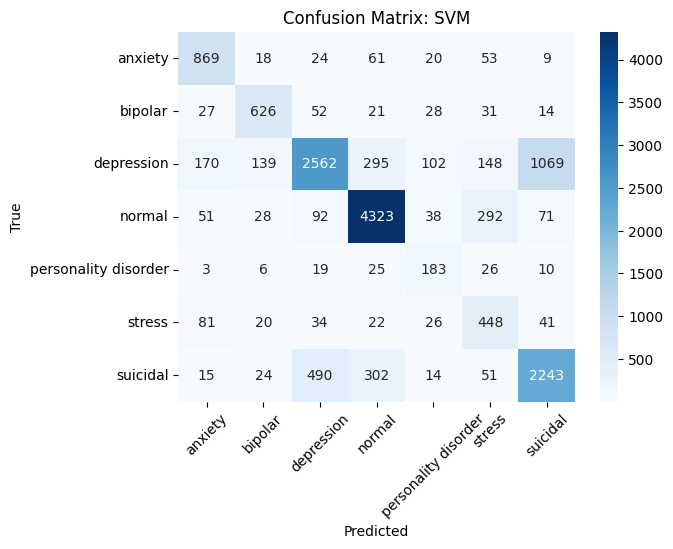

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, svm_predictions)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: SVM")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plot_f1_perclass(y_test, svm_predictions, label_encoder)

XGB BOOST??

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# train XGB classifier
xgb_classifier = XGBClassifier(learning_rate = 0.2, max_depth = 8, n_estimators = 200, random_state = 42, tree_method='gpu_hist')

super long training time(16ms) try later with tree_method='gpu_hist'

In [ ]:
xgb_classifier.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:41:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# test and evaluate
xgb_predictions = xgb_classifier.predict(x_test_combined)

In [ ]:
print("Classification Report - XGB Classifier:")
print(classification_report(y_test, xgb_predictions))

print("F1 Micro:", f1_score(y_test, xgb_predictions, average="micro"))
print("F1 Macro:", f1_score(y_test, xgb_predictions, average="macro"))

Classification Report - XGB Classifier:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1054
           1       0.82      0.77      0.79       799
           2       0.75      0.65      0.70      4485
           3       0.90      0.90      0.90      4895
           4       0.67      0.56      0.61       272
           5       0.47      0.65      0.54       672
           6       0.65      0.72      0.68      3139

    accuracy                           0.76     15316
   macro avg       0.72      0.72      0.72     15316
weighted avg       0.77      0.76      0.76     15316

F1 Micro: 0.7620135805693392
F1 Macro: 0.7161513331161077


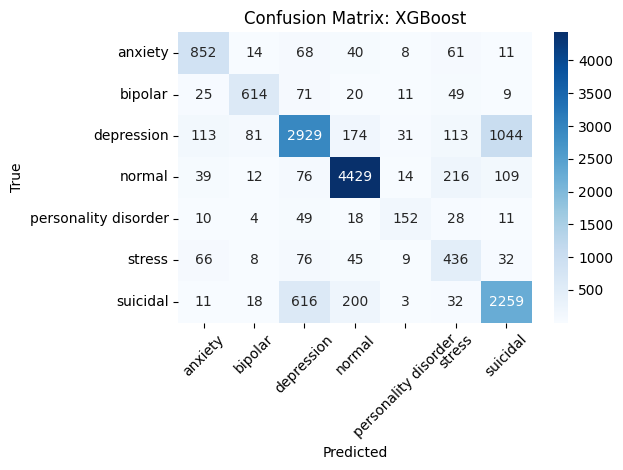

In [ ]:
plot_cm(y_test, xgb_predictions, labels, "Confusion Matrix: XGBoost")

In [ ]:
plot_f1_perclass(y_test, xgb_predictions, label_encoder)

MODELS COMPARISONS

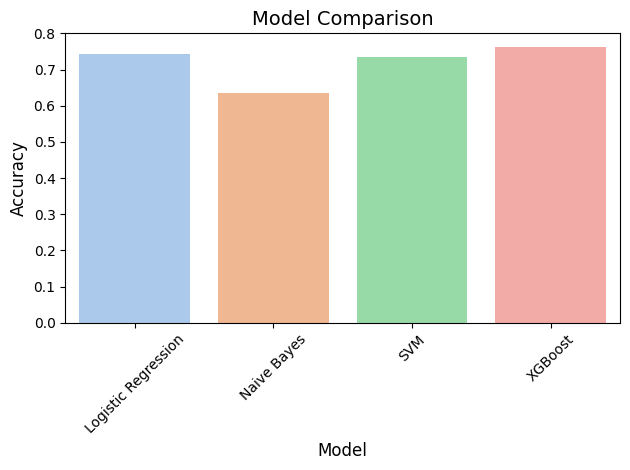

In [ ]:
accuracy_scores = [accuracy_score(y_test, pred_labels), accuracy_score(y_test, nb_predictions),
                   accuracy_score(y_test, svc_predictions), accuracy_score(y_test, xgb_predicitions)]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]


sns.barplot(x = models, y = accuracy_scores, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Among all models, XGBoost achieved the highest accuracy of 0.76, closely followed by Logistic Regression and SVM. The Naive Bayes classifier performed the worst.

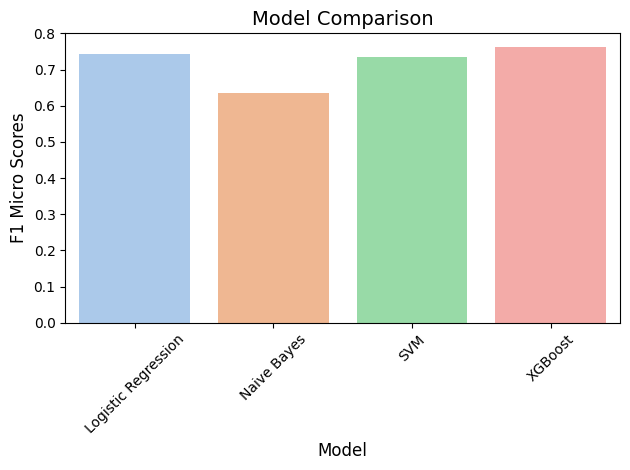

In [ ]:
f1_scores_micro = [f1_score(y_test, pred_labels, average="micro"), f1_score(y_test, nb_predictions, average="micro"),
                   f1_score(y_test, svc_predictions, average="micro"), f1_score(y_test, xgb_predicitions, average="micro")]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]

sns.barplot(x = models, y = f1_scores_micro, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Micro Scores", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

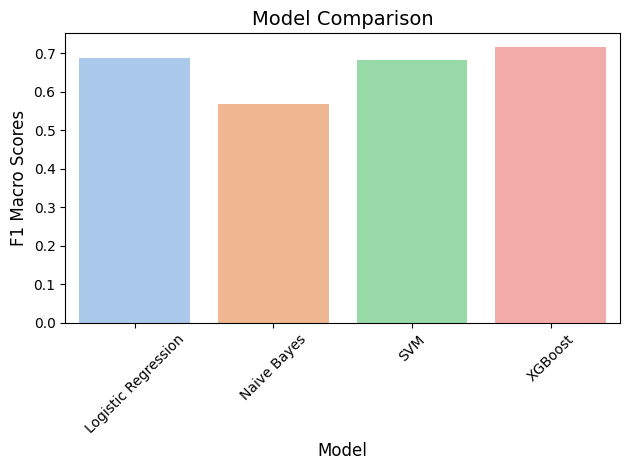

In [ ]:
f1_scores_macro = [f1_score(y_test, pred_labels, average="macro"), f1_score(y_test, nb_predictions, average="macro"),
                   f1_score(y_test, svc_predictions, average="macro"), f1_score(y_test, xgb_predicitions, average="macro")]

models = ["Logistic Regression", "Naive Bayes", "SVM", "XGBoost"]

sns.barplot(x = models, y = f1_scores_macro, hue = models, legend = False, palette = 'pastel')

plt.title("Model Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Macro Scores", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

evaluate!!!

## 4. Deep Learning Approach (PyTorch)

To evaluate whether deep neural networks can improve classification performance over classical machine learning models, a feedforward neural network was implemented usign PyTorch. The model is trained to predict mental health status simply based on TF-IDF vectorized text data.

### 4.1 Data preparation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [ ]:
# define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1 Data Preparation

In [ ]:
x = data["statement"]
y = data['status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words = "english", max_features = 5000)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)


# handle class imbalances with oversampling
ros = RandomOverSampler(random_state=101)
train_vectors, y_train = ros.fit_resample(train_vectors, y_train)

# encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [ ]:
# convert matrices to tensors
train_arr = train_vectors.toarray()
test_arr = test_vectors.toarray()

x_train_tensor = torch.tensor(train_arr, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype = torch.long)

x_test_tensor = torch.tensor(test_arr, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype = torch.long)

# create PyTorch datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64)

In [ ]:
# number of features
input_dim = x_train_tensor.shape[1]

In [ ]:
class ShallowNNClassifier(nn.Module):
    """
    A simple feedforward neural network with one hidden layer.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(ShallowNNClassifier, self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.3)
      self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      x = self.dropout(self.relu(self.fc1(x)))
      return self.fc2(x)

In [ ]:
# initalize model, loss function, and optimizer
model_shallow = ShallowNNClassifier(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_shallow.parameters(), lr = 0.01)

In [ ]:
# training function

def train_NN(model, train_loader, criterion, optimizer, device, num_epochs = 10):
  model.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_x)
      loss = criterion(outputs, batch_y)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss: .4f}")

In [ ]:
# evaluation function

def evaluate_NN(model, test_loader, label_encoder, y_test):
  model.eval()
  all_predictions = []
  with torch.no_grad():
    for batch_x, _ in test_loader:
      batch_x = batch_x.to(device)
      outputs = model(batch_x)
      predictions = torch.argmax(outputs, dim = 1)
      all_predictions.extend(predictions.cpu().numpy())

    y_predictions_labels = label_encoder.inverse_transform(all_predictions)

    print(classification_report(y_test, y_predictions_labels))
    print("F1 Micro:", f1_score(y_test, y_predictions_labels, average="micro"))
    print("F1 Macro:", f1_score(y_test, y_predictions_labels, average="macro"))


In [ ]:
train_NN(model_shallow, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss:  562.1857
Epoch 2/10, Loss:  231.8585
Epoch 3/10, Loss:  146.4097
Epoch 4/10, Loss:  100.4050
Epoch 5/10, Loss:  78.0362
Epoch 6/10, Loss:  67.2932
Epoch 7/10, Loss:  57.3706
Epoch 8/10, Loss:  52.7053
Epoch 9/10, Loss:  47.3816
Epoch 10/10, Loss:  44.2986


In [ ]:
evaluate_NN(model_shallow, test_loader, label_encoder, y_test)

                      precision    recall  f1-score   support

             anxiety       0.77      0.74      0.75      1054
             bipolar       0.85      0.66      0.74       799
          depression       0.64      0.73      0.68      4485
              normal       0.87      0.91      0.89      4895
personality disorder       0.81      0.49      0.61       272
              stress       0.59      0.39      0.47       672
            suicidal       0.63      0.57      0.60      3139

            accuracy                           0.73     15316
           macro avg       0.74      0.64      0.68     15316
        weighted avg       0.73      0.73      0.73     15316

F1 Micro: 0.7320449203447376
F1 Macro: 0.6773717060656363


performance still is very similar to the baseline model so lets try to add more depth

In [ ]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(DeepNN, self).__init__()
      self.fc1 = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.3)
      self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)

      return x



In [ ]:
model_deep = DeepNN(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deep.parameters(), lr = 0.01)

In [ ]:
train_NN(model_deep, train_loader, criterion, optimizer, device)

In [ ]:
evaluate_NN(model_deep, test_loader, label_encoder, y_test)

In [ ]:
class DeepNNBatch(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNNBatch, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
model_deepbatch = DeepNNBatch(input_dim = input_dim, hidden_dim = 128, output_dim = num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deepbatch.parameters(), lr = 0.01)

In [ ]:
train_NN(model_deepbatch, train_loader, criterion, optimizer, device)

In [ ]:
evaluate_NN(model_deepbatch, test_loader, label_encoder, y_test)

The Shallow Neural Network actually performed the best across accuracy, F1 micro, and F1 macro, despite being the simplest. It offers: best general performance across classes, lower training time and less risk of overfitting compared to deeper variants.

Still, the baseline models like logsitic regression, SVM and XGBoost perform better than NN model. This might be because of few reasons.
- TF-IDF vectors provide a sparse and high-dimensional input. While classical models handle it pretty well, neural networks (especially when not deep enough) may struggle with this kind of output.(this one i don't think so?)

- TF-IDF ignores syntax, grammar and word order which works well for baseline models as they can extract signals based on single words, but in NNs context could be valuable.
- optimization challenges: NNs have much more parameters such as learning rates, weight initalization, early stopping etc. which can also influence results.


Future remarks? something like